#VGG16 Model Experiments
In this notebook, vgg16 model will be experimented to find out the best model for GTSRB dataset.

#Mount Google Drive and import libraries

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

Mounted at /content/drive


In [ ]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import random

# Set the seed
random.seed(42)

#Dataset:

##Load training data

In [ ]:
# Define paths to dataset
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size
IMG_SIZE = 32  # Resize images
num_classes = 43

# Define function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays and normalize
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes)  # One-hot encode labels

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

## Print total number of images in the training dataset

In [ ]:
# Store the images and labels in two new folders
train_images, train_labels = images, labels

# Print dataset shape
print(f'train_images shape: {train_images.shape}')
print(f'train_labels shape: {train_labels.shape}')

train_images shape: (39209, 32, 32, 3)
train_labels shape: (39209, 43)


##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 80% of the dataset will be used for training, and the remaining 20% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [ ]:
train_images, train_labels = images, labels

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (31367, 32, 32, 3)
Validation data shape: (7842, 32, 32, 3)


## Load test data

In [ ]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32') / 255.0  # Normalize images

    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

Skipping non-image file: GT-final_test.test.csv


##Total Number of images in the test data

In [ ]:
# Print test dataset shape
print(f'X_test shape: {X_test.shape}')

X_test shape: (12630, 32, 32, 3)


##Load ground truth

In [ ]:
# Load the ground truth file (downloaded separately)
ground_truth = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

#Compile and train model

In [ ]:
# define a function to train the model
def train_model(model, lr, BATCH_SIZE, EPOCHS):
    """
    This function will train the model.
    Parameters:
        model: the model that will be trained
        lr: learning rate
        BATCH_SIZE: batch size
        EPOCHS: number of epochs
    """
    # Initialize EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        callbacks=[early_stopping]
    )

    return history

#Accuracy and loss curve

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# write a function to visualize curves
def visualize_training_curves(history):

    """
    This function will plot the accuracy and loss curve of the trained model.
    parameter:
        history: It contains taining history of the model
    """

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # set epochs to start from 1
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    axes[0].plot(epochs, history.history['accuracy'], label='train_accuracy', color="blue")
    axes[0].plot(epochs, history.history['val_accuracy'], label='val_accuracy', color="orange")
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylim(0, 1)
    axes[0].legend(loc='lower right')
    axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    # Plot loss
    axes[1].plot(epochs, history.history['loss'], label='train_loss', color="green")
    axes[1].plot(epochs, history.history['val_loss'], label='val_loss', color="red")
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
    axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))  # Set x-axis ticks as integers because epochs can't be float

    plt.tight_layout()
    plt.show()

#Evaluate model on test data

In [ ]:
# Write a function to evaluate the trained model
def evaluate_model(model, X_test, ground_truth_df):

    """
    This function will evaluate the trained model on test data.
    Parameters:
        model: The trained model
        X_test: contains the test dataset
        ground_truth: contains the true class of the test images
    """

    # Predict class probabilities
    predictions = model.predict(X_test)

    # Get the class index with the highest probability
    predicted_classes = np.argmax(predictions, axis=1)

    # Save predicted classes and the image file names to a dataframe
    predictions_df = pd.DataFrame({
        'Filename': test_img_names,
        'Predicted Class': predicted_classes
    })

    # Ensure the filenames are sorted in ascending order in the result file
    predictions_df = predictions_df.sort_values(by='Filename')

    # Merge both dataframes on the 'Filename' column
    merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

    # Calculate accuracy by comparing predicted classes with actual classes
    accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

    print(f"Learning rate: {lr},\nBatch Size: {BATCH_SIZE},")

    # get the lowest validation loss epoch
    epoch_with_lowest_val_loss = np.argmin(history.history['val_loss'])

    # get validation accuracy of that epoch
    val_accuracy = history.history['val_accuracy'][epoch_with_lowest_val_loss]

    # print validation accuracy and test accuracy
    print(f"Validation accuracy: {val_accuracy*100:.2f}%,\nTest Accuracy: {accuracy * 100:.2f}%.")

#Load Model:

###Trainable base model layers: 0, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,001,451 (57.23 MB)

 Trainable params: 285,739 (1.09 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

##Compile and train the model

Trainable base model layers: 0
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.4325 - loss: 1.9976 - val_accuracy: 0.6589 - val_loss: 1.1013
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6788 - loss: 1.0266 - val_accuracy: 0.7244 - val_loss: 0.8554
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7457 - loss: 0.7998 - val_accuracy: 0.7814 - val_loss: 0.6955
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7842 - loss: 0.6704 - val_accuracy: 0.7939 - val_loss: 0.6341
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.8208 - loss: 0.5641 - val_accuracy: 0.8117 - val_loss: 0.5814


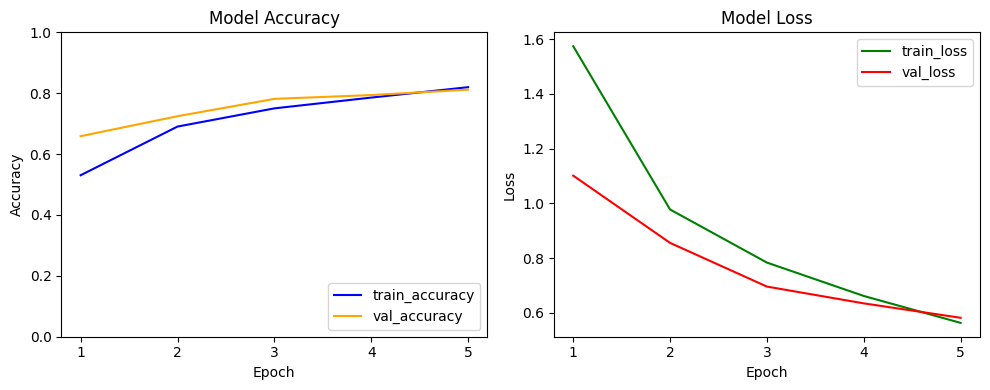

395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 81.17%,
Test Accuracy: 52.23%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: 0\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

#Load Model:

###Trainable base model layers: Last 4, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of base model
for layer in base_model.layers[:15]:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,001,451 (57.23 MB)

 Trainable params: 7,365,163 (28.10 MB)

 Non-trainable params: 7,636,288 (29.13 MB)

##Compile and train the model

Trainable base model layers: Last 4
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.5147 - loss: 1.6402 - val_accuracy: 0.2269 - val_loss: 4.1110
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.7885 - loss: 0.6516 - val_accuracy: 0.7808 - val_loss: 0.6555
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.8716 - loss: 0.3874 - val_accuracy: 0.8720 - val_loss: 0.3597
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.9035 - loss: 0.2859 - val_accuracy: 0.8358 - val_loss: 0.5106
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9233 - loss: 0.2256 - val_accuracy: 0.8897 - val_loss: 0.3674


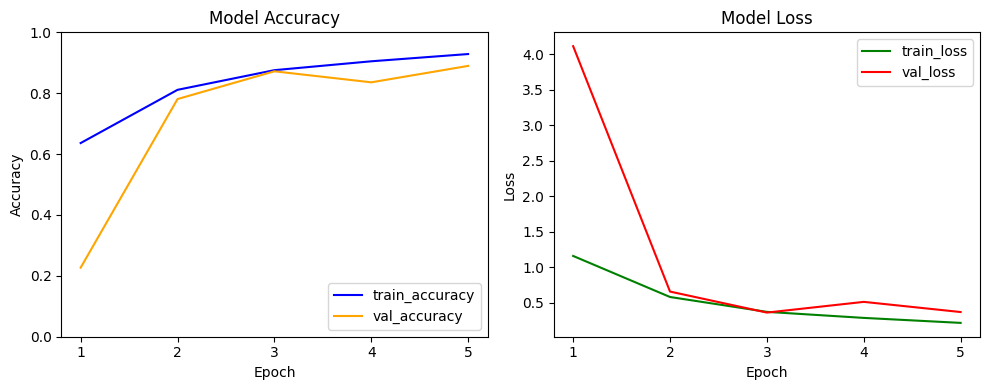

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 87.20%,
Test Accuracy: 69.53%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Last 4\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

#Load Model:

###Trainable base model layers: Last 8, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of base model
for layer in base_model.layers[:11]:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,001,451 (57.23 MB)

 Trainable params: 13,264,939 (50.60 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

##Compile and train the model

Trainable base model layers: Last 8
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 40s 36ms/step - accuracy: 0.2624 - loss: 2.4631 - val_accuracy: 0.5797 - val_loss: 1.2731
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - accuracy: 0.5662 - loss: 1.2851 - val_accuracy: 0.6400 - val_loss: 1.0394
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.7082 - loss: 0.8364 - val_accuracy: 0.7873 - val_loss: 0.6200
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.7995 - loss: 0.5883 - val_accuracy: 0.8076 - val_loss: 0.5918
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.8509 - loss: 0.4433 - val_accuracy: 0.8145 - val_loss: 0.5205


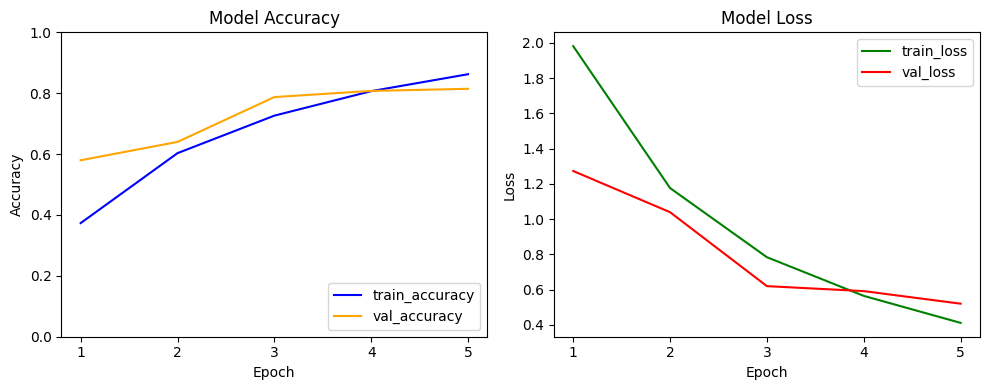

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 81.45%,
Test Accuracy: 71.28%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Last 8\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

#Load Model:

###Trainable base model layers: Last 14, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of base model
for layer in base_model.layers[:5]:
    layer.trainable = False

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,001,451 (57.23 MB)

 Trainable params: 14,887,851 (56.79 MB)

 Non-trainable params: 113,600 (443.75 KB)

##Compile and train the model

Trainable base model layers: Last 14
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 44s 38ms/step - accuracy: 0.2221 - loss: 2.6060 - val_accuracy: 0.5705 - val_loss: 1.3075
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.6681 - loss: 1.0096 - val_accuracy: 0.8063 - val_loss: 0.5679
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8353 - loss: 0.5146 - val_accuracy: 0.8744 - val_loss: 0.4186
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8957 - loss: 0.3292 - val_accuracy: 0.8675 - val_loss: 0.4416
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.9275 - loss: 0.2358 - val_accuracy: 0.9461 - val_loss: 0.1901


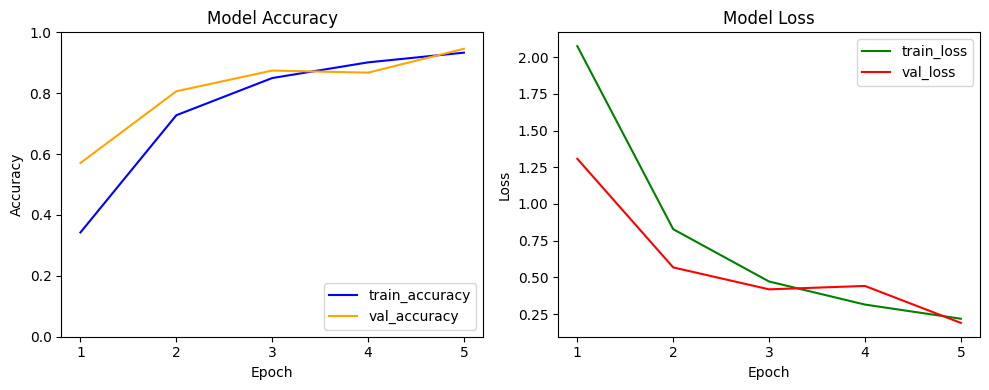

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 94.61%,
Test Accuracy: 89.06%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: Last 14\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

#Load Model:

###Trainable base model layers: All, Learning rate: 0.001, Batch size = 32

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze all layers of base model
for layer in base_model.layers:
    layer.trainable = True

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax activation

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 1, 1, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,001,451 (57.23 MB)

 Trainable params: 15,000,427 (57.22 MB)

 Non-trainable params: 1,024 (4.00 KB)

##Compile and train the model

Trainable base model layers: All
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 47s 41ms/step - accuracy: 0.1856 - loss: 2.8218 - val_accuracy: 0.5509 - val_loss: 1.3100
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 74s 37ms/step - accuracy: 0.6234 - loss: 1.1460 - val_accuracy: 0.5328 - val_loss: 1.5652
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.7402 - loss: 0.7779 - val_accuracy: 0.7263 - val_loss: 0.8868
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 42s 38ms/step - accuracy: 0.8235 - loss: 0.5248 - val_accuracy: 0.7888 - val_loss: 0.6321
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.8802 - loss: 0.3536 - val_accuracy: 0.9373 - val_loss: 0.2106


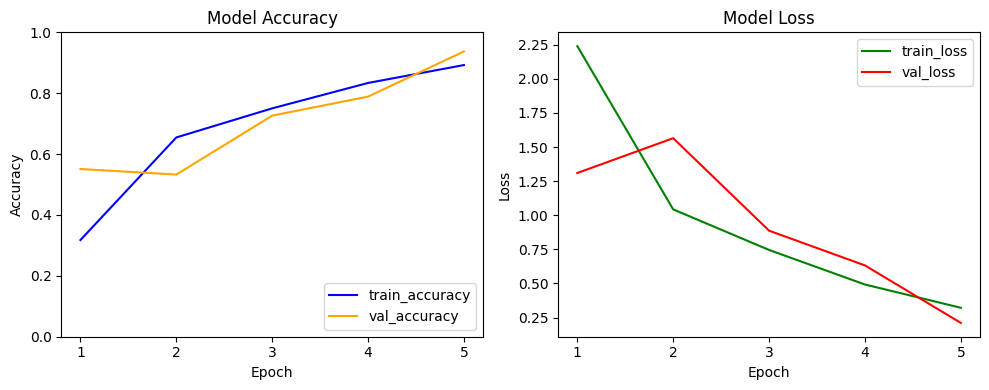

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 93.73%,
Test Accuracy: 88.48%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Trainable base model layers: All\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

#Load Model:

##Split the vgg16 model: Train only first 2 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('block1_pool').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Freeze all layers of base model
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_22, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<BatchNormalization name=batch_normalization_22, built=True>
<Flatten name=flatten_22, built=True>
<Dense name=dense_44, built=True>
<Dense name=dense_45, built=True>


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,450,155 (32.23 MB)

 Trainable params: 8,450,027 (32.23 MB)

 Non-trainable params: 128 (512.00 B)

##Compile and train the model

Train only first 2 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8025 - loss: 0.8383 - val_accuracy: 0.9756 - val_loss: 0.1146
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.9944 - loss: 0.0364 - val_accuracy: 0.9749 - val_loss: 0.0950
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9990 - loss: 0.0116 - val_accuracy: 0.9704 - val_loss: 0.1124
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9987 - loss: 0.0092 - val_accuracy: 0.9671 - val_loss: 0.1209
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9975 - loss: 0.0133 - val_accuracy: 0.9927 - val_loss: 0.0326


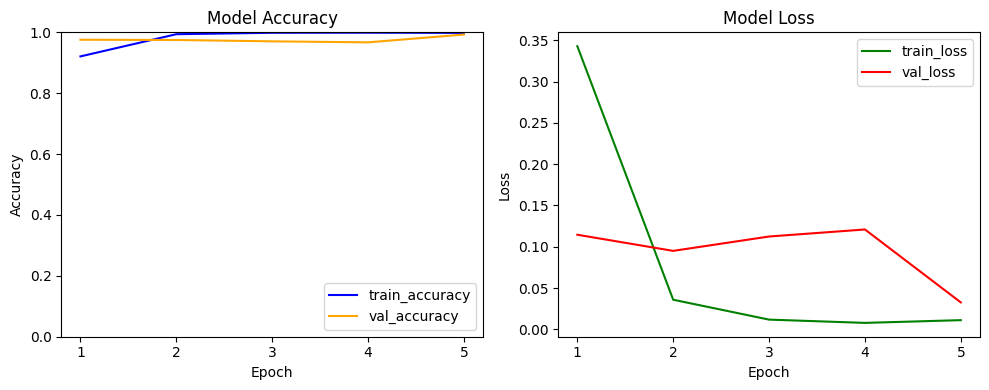

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.27%,
Test Accuracy: 95.69%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 2 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

#Load Model:

##Split the vgg16 model: Train only first 4 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('block2_pool').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Freeze all layers of base model
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_23, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<BatchNormalization name=batch_normalization_23, built=True>
<Flatten name=flatten_23, built=True>
<Dense name=dense_46, built=True>
<Dense name=dense_47, built=True>


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,477,547 (17.08 MB)

 Trainable params: 4,477,291 (17.08 MB)

 Non-trainable params: 256 (1.00 KB)

##Compile and train the model

Train only first 4 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.9005 - loss: 0.4125 - val_accuracy: 0.9809 - val_loss: 0.0807
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9963 - loss: 0.0148 - val_accuracy: 0.9843 - val_loss: 0.0426
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9836 - val_loss: 0.0627
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9955 - loss: 0.0171 - val_accuracy: 0.9959 - val_loss: 0.0148
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9987 - loss: 0.0054 - val_accuracy: 0.9980 - val_loss: 0.0079


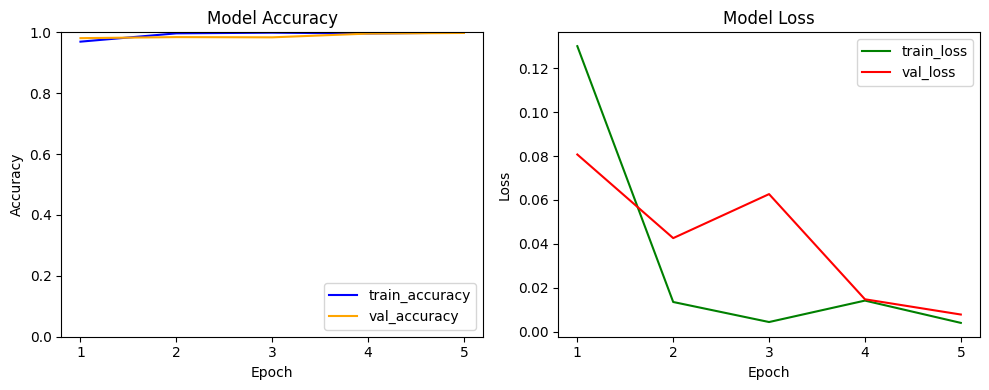

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.80%,
Test Accuracy: 98.11%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 4 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

#Load Model:

##Split the vgg16 model: Train only first 7 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('block3_pool').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Freeze all layers of base model
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_24, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<BatchNormalization name=batch_normalization_24, built=True>
<Flatten name=flatten_24, built=True>
<Dense name=dense_48, built=True>
<Dense name=dense_49, built=True>


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,856,235 (14.71 MB)

 Trainable params: 3,855,723 (14.71 MB)

 Non-trainable params: 512 (2.00 KB)

##Compile and train the model

Train only first 7 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8483 - loss: 0.5653 - val_accuracy: 0.9852 - val_loss: 0.0547
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9920 - loss: 0.0295 - val_accuracy: 0.9920 - val_loss: 0.0319
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.9926 - loss: 0.0280 - val_accuracy: 0.9920 - val_loss: 0.0301
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9954 - loss: 0.0173 - val_accuracy: 0.9921 - val_loss: 0.0238
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9969 - loss: 0.0113 - val_accuracy: 0.9941 - val_loss: 0.0196


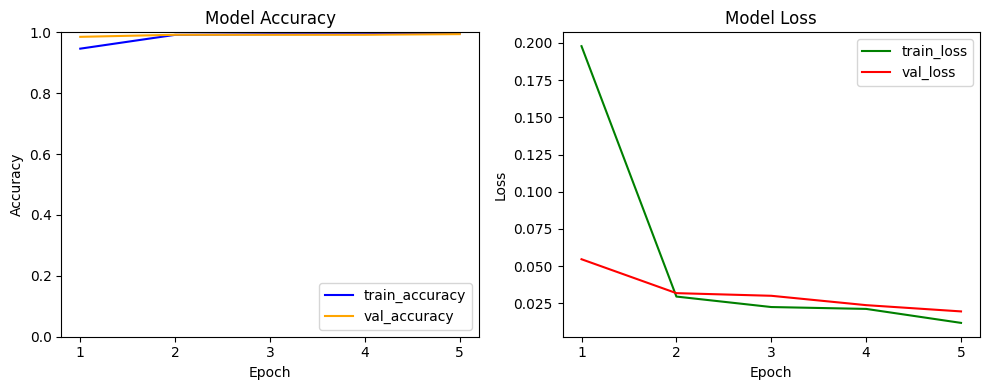

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.41%,
Test Accuracy: 96.03%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 7 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

#Load Model

##Split the vgg16 model: Train only first 10 convolutional layers with the top layers

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras import models

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Add new layers on top of the base model
model = Sequential()
model.add(base_model)

# Continue with your custom layers
x = base_model.get_layer('block4_pool').output
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='sigmoid')(x)
out = Dense(43, activation='softmax')(x)

model = models.Model(inputs = base_model.input, outputs = out, name='model')

# Freeze all layers of base model
for layer in model.layers:
    layer.trainable = True
    print(layer)

model.summary()

<InputLayer name=input_layer_25, built=True>
<Conv2D name=block1_conv1, built=True>
<Conv2D name=block1_conv2, built=True>
<MaxPooling2D name=block1_pool, built=True>
<Conv2D name=block2_conv1, built=True>
<Conv2D name=block2_conv2, built=True>
<MaxPooling2D name=block2_pool, built=True>
<Conv2D name=block3_conv1, built=True>
<Conv2D name=block3_conv2, built=True>
<Conv2D name=block3_conv3, built=True>
<MaxPooling2D name=block3_pool, built=True>
<Conv2D name=block4_conv1, built=True>
<Conv2D name=block4_conv2, built=True>
<Conv2D name=block4_conv3, built=True>
<MaxPooling2D name=block4_pool, built=True>
<BatchNormalization name=batch_normalization_25, built=True>
<Flatten name=flatten_25, built=True>
<Dense name=dense_50, built=True>
<Dense name=dense_51, built=True>


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,708,459 (33.22 MB)

 Trainable params: 8,707,435 (33.22 MB)

 Non-trainable params: 1,024 (4.00 KB)

##Compile and train the model

Train only first 10 convolutional layers with the top layers
Training model with Learning rate = 0.001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step - accuracy: 0.3557 - loss: 2.2847 - val_accuracy: 0.9308 - val_loss: 0.2162
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9613 - loss: 0.1302 - val_accuracy: 0.9698 - val_loss: 0.1005
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9804 - loss: 0.0658 - val_accuracy: 0.9705 - val_loss: 0.0893
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9872 - loss: 0.0431 - val_accuracy: 0.9825 - val_loss: 0.0562
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.9899 - loss: 0.0353 - val_accuracy: 0.9754 - val_loss: 0.0793


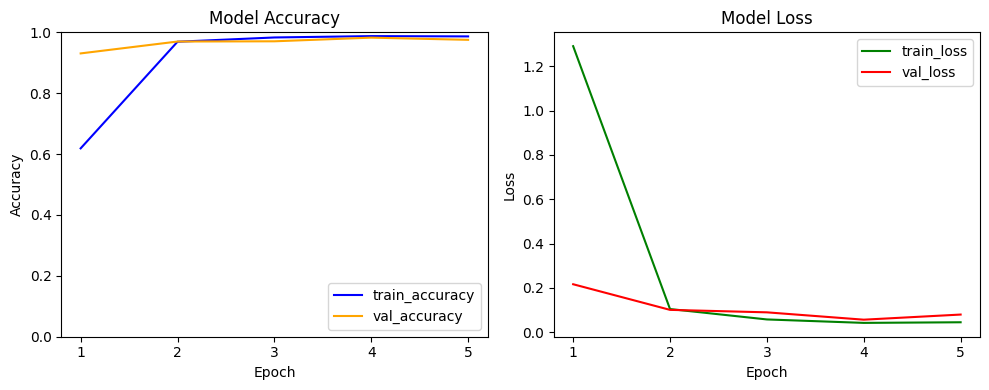

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.25%,
Test Accuracy: 93.54%.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# set model parameters
BATCH_SIZE = 32
lr = 0.001

# Set epochs
EPOCHS = 5

print(f"Train only first 10 convolutional layers with the top layers\nTraining model with Learning rate = {lr} and Batch Size = {BATCH_SIZE}")

# Call train model function
history = train_model(model, lr, BATCH_SIZE, EPOCHS)

# Call visualize training curve function
visualize_training_curves(history)

#call evaluate model fucntion
evaluate_model(model, X_test, ground_truth)

##Layer experiments Results:
Trainable base model layers: 0
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 81.17%,
Test Accuracy: 52.23%.

Trainable base model layers: Last 4
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 87.20%,
Test Accuracy: 69.53%.

Trainable base model layers: last 8
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 81.45%,
Test Accuracy: 71.28%.

Trainable base model layers: Last 14
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 94.61%,
Test Accuracy: 89.06%.

Trainable base model layers: All
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 93.73%,
Test Accuracy: 88.48%.

##Split vgg16 Model:
Train first 2 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.27%,
Test Accuracy: 95.69%.

Train first 4 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.80%,
Test Accuracy: **98.11%**.

Train first 7 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.41%,
Test Accuracy: 96.03%.

Train first 10 convolutional layers,
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 98.25%,
Test Accuracy: 93.54%.



#Learning Rate (LR) experiments

In the following cell, different learning rates will be experimented on the model. The batch size will be set to 32 during learning rate experiments. During experiments model will be trained for 5 epochs only. Then the best models will be trained for more epochs.

##Split the vgg16 model: Train only the first 4 convolutional layers

In [ ]:
# write a function to load vgg16 model
def load_vgg16_model_4_conv_layer(input_shape):

    """
    This function will load vgg16 model with its all base model layers as trainable
    It will accept input shape as parameter
    """
    # Load the VGG16 base model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

    # Add new layers on top of the base model
    model = Sequential()
    model.add(base_model)

    # Continue with your custom layers
    x = base_model.get_layer('block2_pool').output
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(512, activation='sigmoid')(x)
    out = Dense(43, activation='softmax')(x)

    model = models.Model(inputs = base_model.input, outputs = out, name='model')

    # Freeze all layers of base model
    for layer in model.layers:
        layer.trainable = True

    return model

# Call the function
model = load_vgg16_model_4_conv_layer((IMG_SIZE, IMG_SIZE, 3))

# Print model summary
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,477,547 (17.08 MB)

 Trainable params: 4,477,291 (17.08 MB)

 Non-trainable params: 256 (1.00 KB)

##Compile and train the model

*********************************************************
Experiment 1 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.0001 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7854 - loss: 0.9818 - val_accuracy: 0.9969 - val_loss: 0.0560
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9991 - loss: 0.0268 - val_accuracy: 0.9977 - val_loss: 0.0209
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.9983 - val_loss: 0.0115
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9983 - val_loss: 0.0088
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.9989 - val_loss: 0.0064


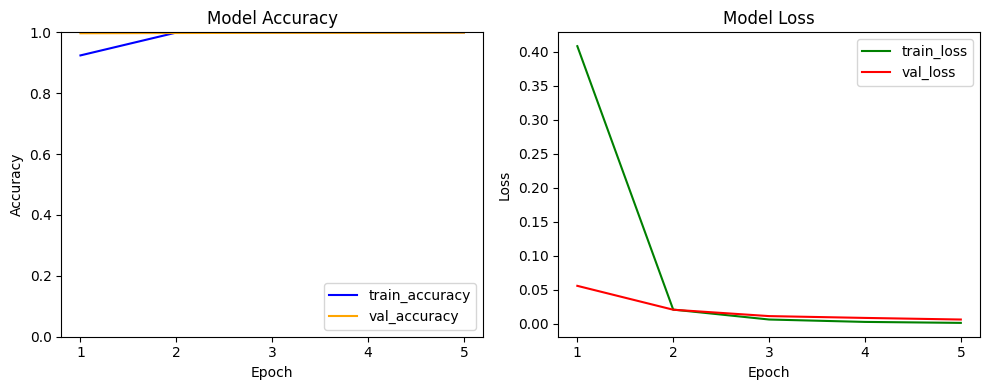

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.89%,
Test Accuracy: 98.80%.
Experiment 1 finish
*********************************************************


*********************************************************
Experiment 2 starts
Train using only first 4 convolution layers
Training model with learning rate = 1e-05 and Batch Size = 32
Epoch 1/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.4300 - loss: 2.4697 - val_accuracy: 0.8207 - val_loss: 1.0645
Epoch 2/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.8791 - loss: 0.8475 - val_accuracy: 0.9480 - val_loss: 0.5091
Epoch 3/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9651 - loss: 0.3997 - val_accuracy: 0.9833 - val_loss: 0.2705
Epoch 4/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9890 - loss: 0.2123 - val_accuracy: 0.9908 - val_loss: 0.1574
Epoch 5/5
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9956 - loss: 0.1225 - val_

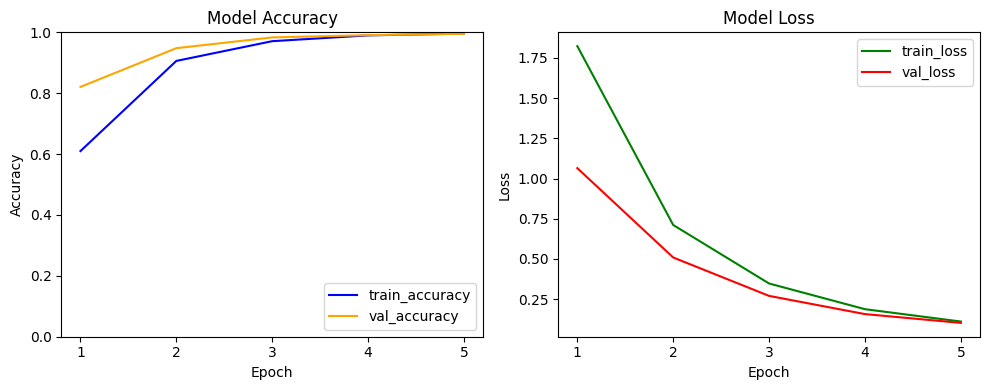

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 1e-05,
Batch Size: 32,
Validation accuracy: 99.52%,
Test Accuracy: 97.30%.
Experiment 2 finish
*********************************************************




In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.0001, 0.00001]
BATCH_SIZE = 32
EPOCHS = 5

loop = 1

for lr in learning_rate:

    print(f'*********************************************************')
    print(f'Experiment {loop} starts')

    print(f"Train using only first 4 convolution layers\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Experiment {loop} finish')
    loop += 1

    print(f'*********************************************************\n\n')

## Learning Rate (LR) experiments results:
###Train first 4 convolutional layers
Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.80%,
Test Accuracy: **98.11%**.

Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.89%,
Test Accuracy: **98.80%**.

Learning rate: 1e-05,
Batch Size: 32,
Validation accuracy: 99.52%,
Test Accuracy: 97.30%.

#Batch Size Experiments

Different batch sizes will be experimented on the model in the following cells with different learning rates.

## Batch Size experiments on vgg16 model: Train only the first 4 convolutional layers

##Compile and train the model

*********************************************************
Batch Size Experiment 1 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.001 and Batch Size = 16
Epoch 1/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9025 - loss: 0.4024 - val_accuracy: 0.9906 - val_loss: 0.0393
Epoch 2/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9962 - loss: 0.0159 - val_accuracy: 0.9950 - val_loss: 0.0202
Epoch 3/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9971 - loss: 0.0112 - val_accuracy: 0.9904 - val_loss: 0.0351
Epoch 4/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9974 - loss: 0.0093 - val_accuracy: 0.9823 - val_loss: 0.0556
Epoch 5/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9959 - loss: 0.0136 - val_accuracy: 0.9939 - val_loss: 0.0213


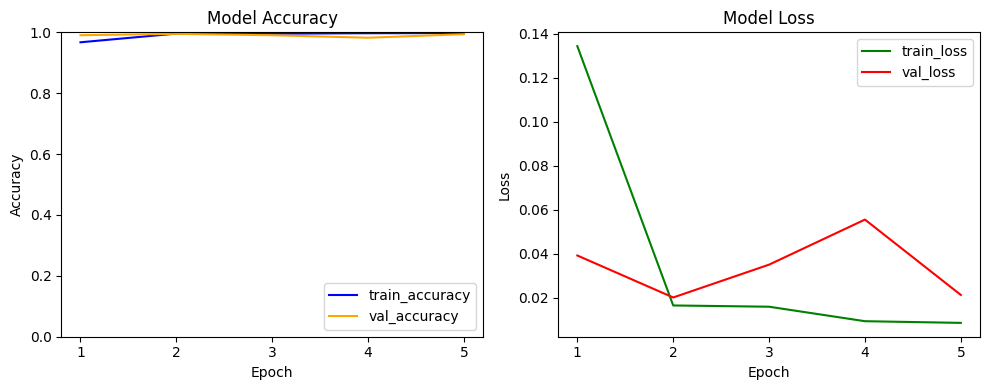

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.50%,
Test Accuracy: 96.48%.
Batch Size Experiment 1 ends
*********************************************************


*********************************************************
Batch Size Experiment 2 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.001 and Batch Size = 64
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.8717 - loss: 0.5252 - val_accuracy: 0.9944 - val_loss: 0.0320
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.9997 - loss: 0.0047 - val_accuracy: 0.9895 - val_loss: 0.0398
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9977 - loss: 0.0117 - val_accuracy: 0.9985 - val_loss: 0.0057
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9999 - loss: 0.0012 - val_accuracy: 0.9986 - val_loss: 0.0046
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 1.0000

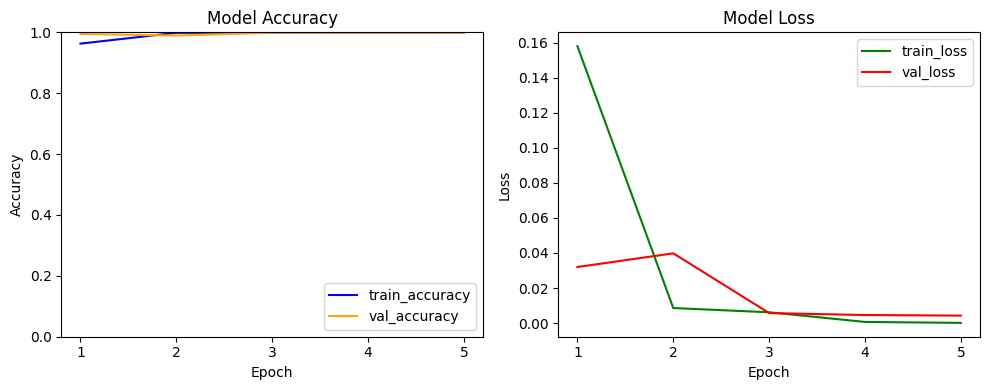

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.87%,
Test Accuracy: 98.76%.
Batch Size Experiment 2 ends
*********************************************************


*********************************************************
Batch Size Experiment 3 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.001 and Batch Size = 128
Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8411 - loss: 0.6369 - val_accuracy: 0.9971 - val_loss: 0.0326
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9999 - loss: 0.0043 - val_accuracy: 0.9977 - val_loss: 0.0122
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9989 - val_loss: 0.0053
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 1.0000 - loss: 4.4646e-04 - val_accuracy: 0.9991 - val_loss: 0.0046
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 1.

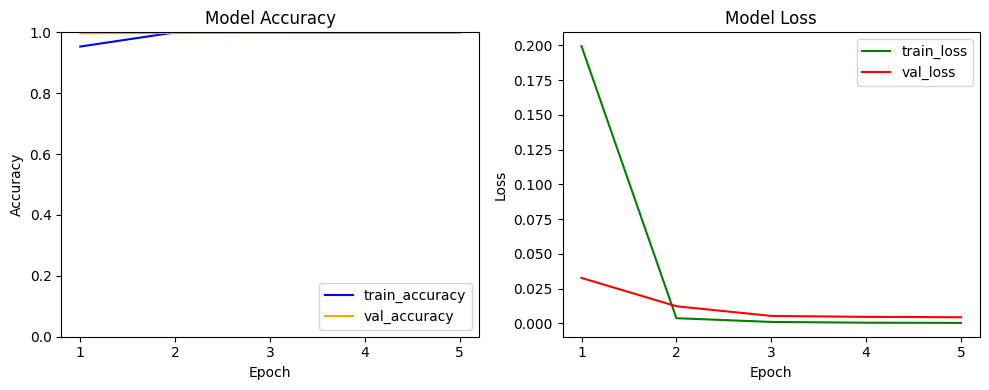

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.90%,
Test Accuracy: 98.80%.
Batch Size Experiment 3 ends
*********************************************************


*********************************************************
Batch Size Experiment 4 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.0001 and Batch Size = 16
Epoch 1/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.8351 - loss: 0.7581 - val_accuracy: 0.9968 - val_loss: 0.0295
Epoch 2/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9997 - loss: 0.0137 - val_accuracy: 0.9989 - val_loss: 0.0123
Epoch 3/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9994 - val_loss: 0.0065
Epoch 4/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9943 - val_loss: 0.0243
Epoch 5/5
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy

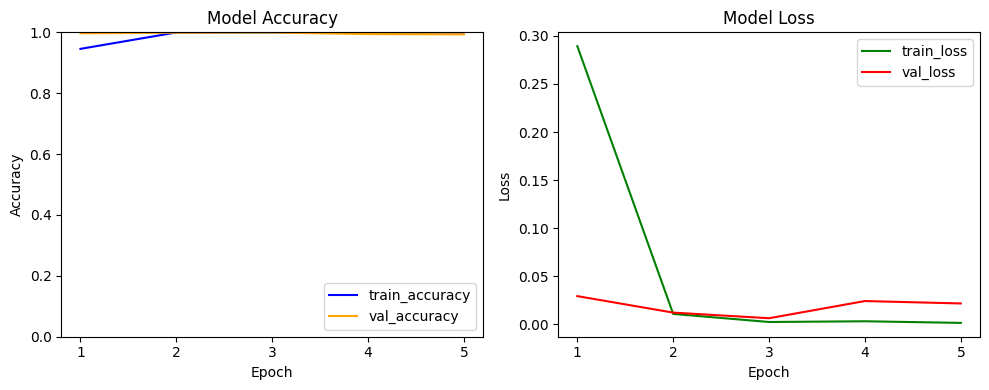

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.94%,
Test Accuracy: 98.46%.
Batch Size Experiment 4 ends
*********************************************************


*********************************************************
Batch Size Experiment 5 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.0001 and Batch Size = 64
Epoch 1/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7300 - loss: 1.2319 - val_accuracy: 0.9888 - val_loss: 0.2112
Epoch 2/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9980 - loss: 0.0519 - val_accuracy: 0.9978 - val_loss: 0.0374
Epoch 3/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9997 - loss: 0.0163 - val_accuracy: 0.9983 - val_loss: 0.0173
Epoch 4/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9998 - loss: 0.0077 - val_accuracy: 0.9986 - val_loss: 0.0122
Epoch 5/5
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 1.000

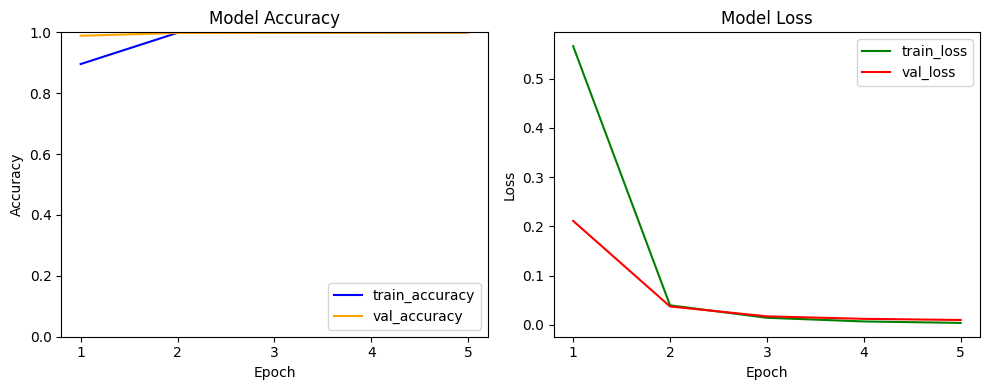

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 99.89%,
Test Accuracy: 98.73%.
Batch Size Experiment 5 ends
*********************************************************


*********************************************************
Batch Size Experiment 6 starts
Train using only first 4 convolution layers
Training model with learning rate = 0.0001 and Batch Size = 128
Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6339 - loss: 1.6232 - val_accuracy: 0.9740 - val_loss: 0.4150
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.9933 - loss: 0.1170 - val_accuracy: 0.9963 - val_loss: 0.0922
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9993 - loss: 0.0380 - val_accuracy: 0.9982 - val_loss: 0.0401
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9999 - loss: 0.0191 - val_accuracy: 0.9987 - val_loss: 0.0223
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 1.00

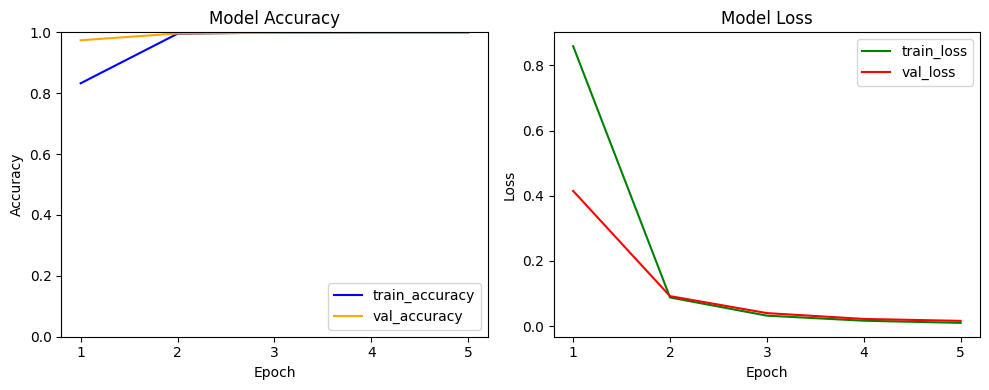

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 128,
Validation accuracy: 99.89%,
Test Accuracy: 98.49%.
Batch Size Experiment 6 ends
*********************************************************




In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.001, 0.0001]
batch_sizes = [16, 64, 128]
EPOCHS = 5

loop = 1

for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Batch Size Experiment {loop} starts')
    print(f"Train using only first 4 convolution layers\nTraining model with learning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Batch Size Experiment {loop} ends')
    loop += 1

    print(f'*********************************************************\n\n')

## Batch size experiments results:
###Train first 4 convolutional layers
Learning rate: 0.001,
Batch Size: 16,
Validation accuracy: 99.50%,
Test Accuracy: 96.48%.

Learning rate: 0.001,
Batch Size: 32,
Validation accuracy: 99.80%,
Test Accuracy: 98.11%.

**Learning rate: 0.001, Batch Size: 64, Validation accuracy: 99.87%, Test Accuracy: 98.76%.**

**Learning rate: 0.001, Batch Size: 128, Validation accuracy: 99.90%, Test Accuracy: 98.80%.**

Learning rate: 0.0001,
Batch Size: 16,
Validation accuracy: 99.94%,
Test Accuracy: 98.46%.

**Learning rate: 0.0001, Batch Size: 32, Validation accuracy: 99.89%, Test Accuracy: 98.80%.**

**Learning rate: 0.0001, Batch Size: 64, Validation accuracy: 99.89%, Test Accuracy: 98.73%.**

Learning rate: 0.0001,
Batch Size: 128,
Validation accuracy: 99.89%,
Test Accuracy: 98.49%.

# Training the best models for more epochs

##Compile and train the model

##Learning rate 0.001

*********************************************************
Training the best models for more epochs
Model 1 training starts
Trainable base model layers: All
Learning rate = 0.001 and Batch Size = 64
Epoch 1/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.8766 - loss: 0.5030 - val_accuracy: 0.9769 - val_loss: 0.0850
Epoch 2/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.9982 - loss: 0.0116 - val_accuracy: 0.9967 - val_loss: 0.0183
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9986 - loss: 0.0064 - val_accuracy: 0.9865 - val_loss: 0.0553
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9970 - loss: 0.0101 - val_accuracy: 0.9982 - val_loss: 0.0079
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 1.0000 - loss: 2.3946e-04 - val_accuracy: 0.9985 - val_loss: 0.0058
Epoch 6/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 1.0000 - loss: 9.2893e-05 - val_accuracy: 0.9986 - val_loss: 0.0056
Epoch 7/50
490/490

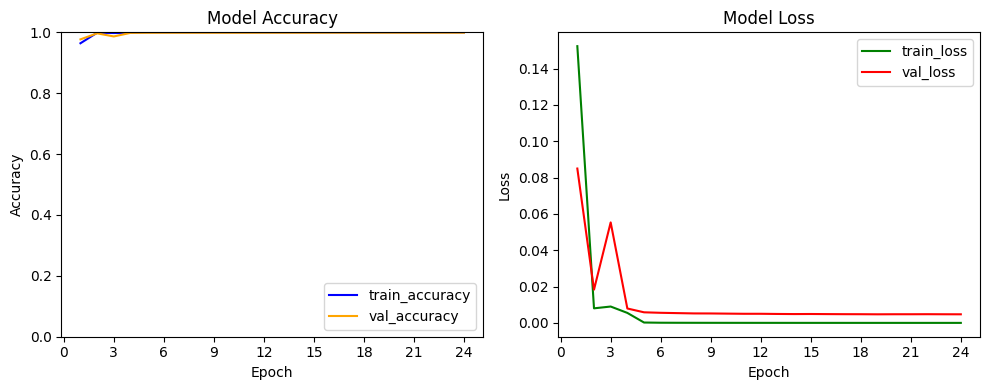

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.89%,
Test Accuracy: 98.66%.
Model 1 ends
*********************************************************


*********************************************************
Training the best models for more epochs
Model 2 training starts
Trainable base model layers: All
Learning rate = 0.001 and Batch Size = 128
Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.8339 - loss: 0.6773 - val_accuracy: 0.9962 - val_loss: 0.0308
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9992 - loss: 0.0065 - val_accuracy: 0.9987 - val_loss: 0.0122
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9991 - val_loss: 0.0049
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 1.0000 - loss: 5.7118e-04 - val_accuracy: 0.9990 - val_loss: 0.0045
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 1.0000 - l

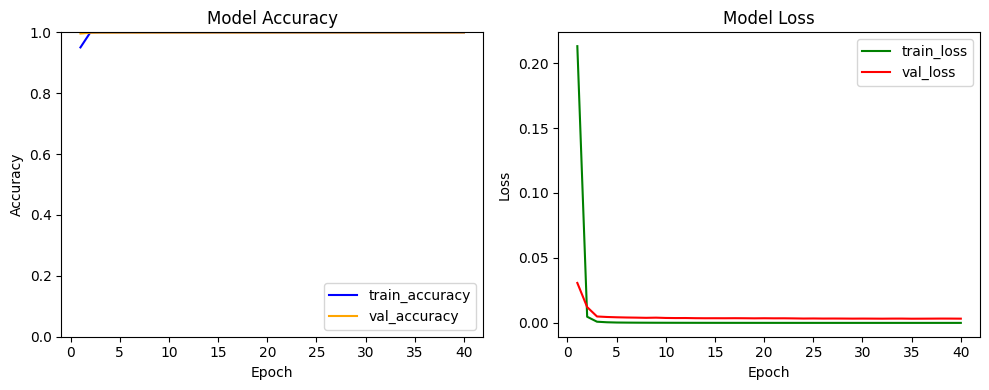

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.94%,
Test Accuracy: 98.98%.
Model 2 ends
*********************************************************




In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.001]
batch_sizes = [64, 128]
EPOCHS = 50

model_counter = 1
for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Training the best models for more epochs')
    print(f'Model {model_counter} training starts')
    print(f"Trainable base model layers: All\nLearning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Model {model_counter} ends')
    model_counter += 1

    print(f'*********************************************************\n\n')

##Compile and train the model

##Learning rate 0.0001

*********************************************************
Training the best models for more epochs
Model 1 training starts
Trainable base model layers: All
Learning rate = 0.0001 and Batch Size = 32
Epoch 1/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7946 - loss: 0.9604 - val_accuracy: 0.9963 - val_loss: 0.0595
Epoch 2/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9991 - loss: 0.0262 - val_accuracy: 0.9982 - val_loss: 0.0195
Epoch 3/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.9990 - val_loss: 0.0100
Epoch 4/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9987 - val_loss: 0.0072
Epoch 5/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.9987 - val_loss: 0.0077
Epoch 6/50
980/980 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9992 - val_loss: 0.0050
Epoch 7/50
980/980 ━━━━━━━━━━━

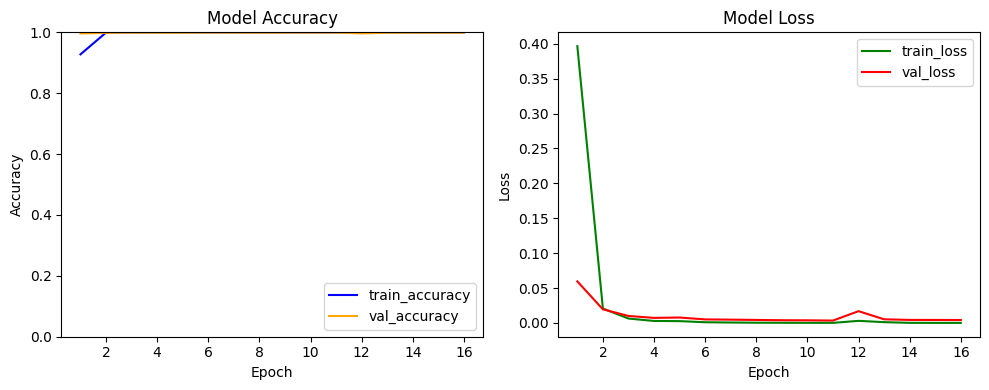

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.92%,
Test Accuracy: 98.93%.
Model 1 ends
*********************************************************


*********************************************************
Training the best models for more epochs
Model 2 training starts
Trainable base model layers: All
Learning rate = 0.0001 and Batch Size = 64
Epoch 1/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7261 - loss: 1.2393 - val_accuracy: 0.9932 - val_loss: 0.1686
Epoch 2/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9974 - loss: 0.0544 - val_accuracy: 0.9976 - val_loss: 0.0358
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9996 - loss: 0.0176 - val_accuracy: 0.9983 - val_loss: 0.0204
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.9987 - val_loss: 0.0140
Epoch 5/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 1.0000 - loss

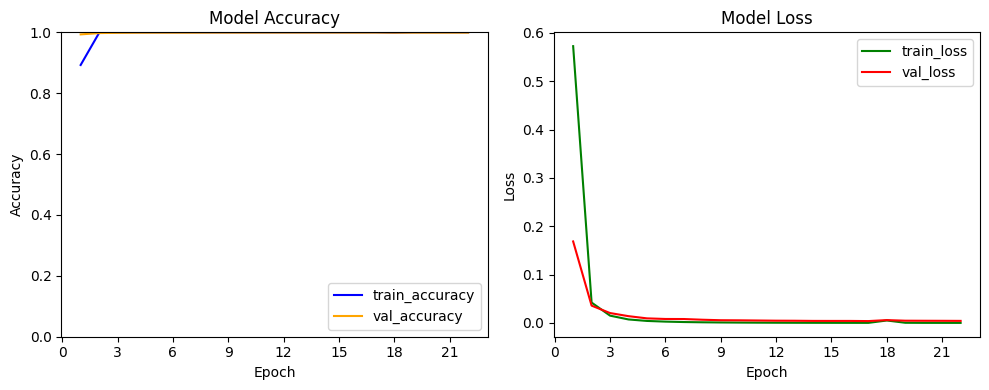

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 99.92%,
Test Accuracy: 98.92%.
Model 2 ends
*********************************************************




In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

learning_rate = [0.0001]
batch_sizes = [32, 64]
EPOCHS = 50

model_counter = 1
for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Training the best models for more epochs')
    print(f'Model {model_counter} training starts')
    print(f"Trainable base model layers: All\nLearning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'Model {model_counter} ends')
    model_counter += 1

    print(f'*********************************************************\n\n')

##Best models with more epochs results:
###Train first 4 convolutional layers
Learning rate: 0.001,
Batch Size: 64,
Validation accuracy: 99.89%,
Test Accuracy: 98.66%.

Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.94%,
Test Accuracy: **98.98%**.

Learning rate: 0.0001,
Batch Size: 32,
Validation accuracy: 99.92%,
Test Accuracy: 98.93%.

Learning rate: 0.0001,
Batch Size: 64,
Validation accuracy: 99.92%,
Test Accuracy: 98.92%.

# Synthetic Minority Oversampling Technique (SMOTE)

Applying Synthetic Minority Oversampling Technique (SMOTE) to over-sample the classes which are under-represented. This helps balance the dataset and improve the performance of machine learning models, particularly for imbalanced classification tasks.

In [ ]:
train_images, train_labels = images, labels

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

train_rows=len(train_images)
train_images = train_images.reshape(train_rows,-1)

train_images, train_labels = sm.fit_resample(train_images, train_labels)
train_images = train_images.reshape(-1,32,32,3)

print(f'Total number of train images and labels after applying SMOTE')
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')

Total number of train images and labels after applying SMOTE
Train images shape: (96750, 32, 32, 3)
Train labels shape: (96750, 43)


##Split dataset into training and validation set
Here, the dataset will be splited into training and validation sets, where 70% of the dataset will be used for training, and the remaining 30% for validation. This keeps a validation set for observing model performance and preventing overfitting while making sure a sufficient training set for model training.

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (77400, 32, 32, 3)
Validation data shape: (19350, 32, 32, 3)


##Compile and train the model

*********************************************************
Training the best model on oversampled dataset
Train using only first 4 convolution layers
Learning rate = 0.001 and Batch Size = 128
Epoch 1/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9154 - loss: 0.3578 - val_accuracy: 0.9980 - val_loss: 0.0109
Epoch 2/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9996 - loss: 0.0029 - val_accuracy: 0.9983 - val_loss: 0.0121
Epoch 3/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9990 - loss: 0.0046 - val_accuracy: 0.9976 - val_loss: 0.0108
Epoch 4/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9988 - val_loss: 0.0045
Epoch 5/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9989 - val_loss: 0.0042
Epoch 6/50
604/604 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.9999 - loss: 4.6712e-04 - val_accuracy: 0.9973 - val_loss: 0.0137
Epoch 7/50
604/604 ━━━━━

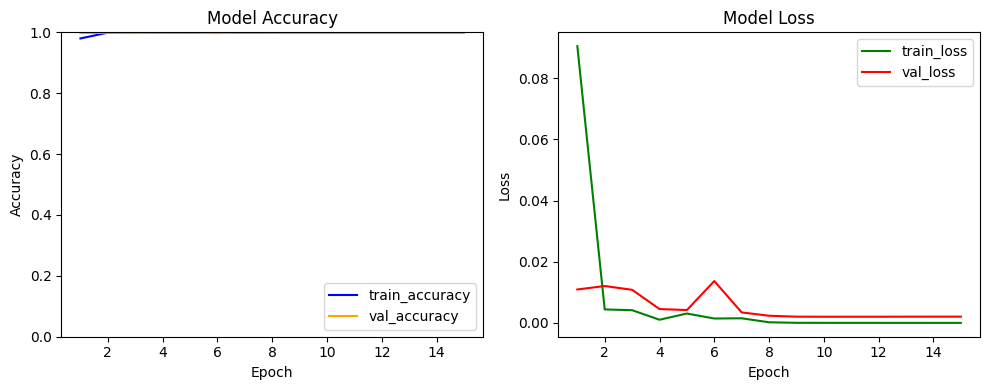

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.95%,
Test Accuracy: 98.60%.
*********************************************************




In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

batch_sizes = [128]
learning_rate = [0.001]
EPOCHS = 50

for lr in learning_rate:
  for BATCH_SIZE in batch_sizes:
    print(f'*********************************************************')
    print(f'Training the best model on oversampled dataset')
    print(f"Train using only first 4 convolution layers\nLearning rate = {lr} and Batch Size = {BATCH_SIZE}")

    # Call create model Function
    model = load_vgg16_model_4_conv_layer((IMG_SIZE,IMG_SIZE, 3))

    # Call train model function
    history = train_model(model, lr, BATCH_SIZE, EPOCHS)

    # Call visualize training curve function
    visualize_training_curves(history)

    #call evaluate model fucntion
    evaluate_model(model, X_test, ground_truth)

    print(f'*********************************************************\n\n')

##Best model on oversampled dataset results:
###Train first 4 convolutional layers
Learning rate: 0.001,
Batch Size: 128,
Validation accuracy: 99.95%,
Test Accuracy: 98.60%.


#Conclusion
Best model parameters: <br>
Learning rate: 0.001<br>
Batch size: 128<br>
Best Accuracy: **98.98%**.

